# Setup

Note: you might need to run `Pkg.instantiate()` to ensure that the `Manifest.toml` is up to date. This only needs to be done once.

In [1]:
import Pkg;
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `/global/u1/b/blaschke/juliacon24-hpcworkshop/parts/distributed/explanation`


Status `/global/u1/b/blaschke/juliacon24-hpcworkshop/parts/distributed/explanation/Project.toml`
  [34f1f09b] ClusterManagers v0.4.6
  [d58978e5] Dagger v0.18.12
  [aaf54ef3] DistributedArrays v0.6.7
  [6f74fd91] NetworkInterfaceControllers v0.1.0
  [91a5bcdd] Plots v1.40.5


# Working with `Distributed.jl` on HPC

As an example: we'll be working with 4 workers (Slurm decides where to place them).

In [2]:
NWORKERS = 4

4

**Disclaimer:** This is a work in progress -- and things will get easier (and better) over time. So keep an eye out for this!

## Using `ElasticManager`

On your laptop you would do something like:

```julia
using Distributed
addprocs(4)
```

On most HPC systems you need to work with a resource manager to request resources. You have two options:
1. Use something like `SlurmManager.jl` to handle talking to your resource manager for you. Pro: when it works it's "cleaner". Con: when it doesn't work, it's harder to fix.
2. Use `ElasticManager` (from `ClusterManagers.jl`) to "wait for" incoming workers. Then have your resource manager to launch workers for you. Pro: more flexible. Con: more work for you.

In [3]:
using Distributed, ClusterManagers

using NetworkInterfaceControllers, Sockets
interfaces = NetworkInterfaceControllers.get_interface_data(IPv4)

hsn0_public = filter(
    x->(x.name=="hsn0:chn" && x.version==:v4), interfaces
) |> only 
hsn0_public.ip

ip"128.55.84.171"

Hack 1: you need all workers to know their public HSN address. In the future this will be automated. Currently what we do is we do is to add the code above to: `$JULIA_DEPOT_PATH/config/startup.jl`:

```julia
using NetworkInterfaceControllers, Sockets
...
Sockets.getipaddr() = hsn0_public.ip
```

In [4]:
em = ElasticManager(addr=hsn0_public.ip, port=10001)  # or use: `addr=:auto`

println(em)

# launch workers
@async run(`srun -n $NWORKERS sh -c $(ClusterManagers.get_connect_cmd(em))`)

# wait for them to connect
while nworkers()<NWORKERS
    println("Waiting for workers, got: $(nworkers())")
    sleep(1)
end

ElasticManager:
  Active workers : []
  Number of workers to be added  : 0
  Terminated workers : []
  Worker connect command : 
    /global/common/software/nersc/n9/julia/1.9.4/bin/julia --project=/global/u1/b/blaschke/juliacon24-hpcworkshop/parts/distributed/explanation/Project.toml -e 'using ClusterManagers; ClusterManagers.elastic_worker("hYwEFbsjp1TfBPEP","128.55.84.171",10001)'
Waiting for workers, got: 1
Waiting for workers, got: 1
Waiting for workers, got: 1
Waiting for workers, got: 1
Waiting for workers, got: 1
Waiting for workers, got: 1
Waiting for workers, got: 1


In [5]:
workers()

4-element Vector{Int64}:
 2
 3
 4
 5

We've got a 4-node job here, so Slurm runs earch worker on a seperate node: 

In [6]:
[@fetchfrom p gethostname() for p in workers()]

4-element Vector{String}:
 "nid200344"
 "nid200345"
 "nid200348"
 "nid200349"

## 1D Solver Example

Let's set up a basic example: 1D diffusion! First we need some parameters:

In [7]:
@everywhere begin
    D  = 1e-4
    ds = 1e-4
    dt = ds^2 / D / 8.2
    qx(ix, D, C, ds) = -D * (C[ix+1, 1] - C[ix, 1]) / ds
end

We can use DistributedArrays to handle to inter-process (inter-rank) communication for you. No more halo exchanges! YAY!

In [8]:
@everywhere using DistributedArrays

In [9]:
ras = [@spawnat p zeros(10, 1) for p in workers()]
ras = reshape(ras, (nworkers(), 1))
C   = DArray(ras)

40×1 DArray{Float64, 2, Matrix{Float64}}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

As the name suggest: `DistributedArrays` store their data accross processes -- this means the global address space is broken up into local parts:

In [10]:
[@fetchfrom p localindices(C) for p in workers()]

4-element Vector{Tuple{UnitRange{Int64}, UnitRange{Int64}}}:
 (1:10, 1:1)
 (11:20, 1:1)
 (21:30, 1:1)
 (31:40, 1:1)

One downslide (which packages like `Dagger.jl` solve is that we can't globally set elements of `DArray`s

In [11]:
C[20,1] = 1/ds

LoadError: CanonicalIndexError: setindex! not defined for DArray{Float64, 2, Matrix{Float64}}

Instead we have to work on the `localparts` and construct a new `DArray`:

In [12]:
target_index = 20
target_value = 1/ds

C = DArray(size(C)) do I
    loc = localpart(C)
    idx = localindices(C)[1] # working in 1D
    
    # If target_index is in the local index, then change the localpart
    if target_index in idx
        loc_i = findfirst(x->x==target_index, idx)
        loc[loc_i] = target_value
    end
    loc
end

40×1 DArray{Float64, 2, Matrix{Float64}}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Sanity check: the "area under the curve" should be 1.

In [13]:
sum(C)*ds

1.0

You can access any part from `DArray` from anywhere (this is what makes them more convenient than MPI, but possibly slower if you use unneccessary communication)

So now we can write our 1D diffusion algorithm :)

In [14]:
function step_diffusion(C)
    DArray(size(C)) do I
        loc = localpart(C)
        idx = localindices(C)[1] # working in 1D

        off = idx[1]-1
        for i in idx
            # absorbing boundary conditions (lo, hi are always set to zero)
            if i==1 || i==size(C, 1)
                continue
            end
            il = i - off
            loc[il] = loc[il] - dt * (qx(i, D, C, ds) - qx(i-1, D, C, ds)) / ds
        end

        loc
    end
end

step_diffusion (generic function with 1 method)

Which we run for 100 time steps. We save every 10th timestep. This is great for debugging and illustration, but it's is super wasteful, don't do this in production

In [15]:
sols = [Array(C)]
for i in 1:100
    C = step_diffusion(C)
    # Save timesteps:
    if i%10 == 0
        push!(sols, Array(C))
    end
end

In [16]:
using Plots

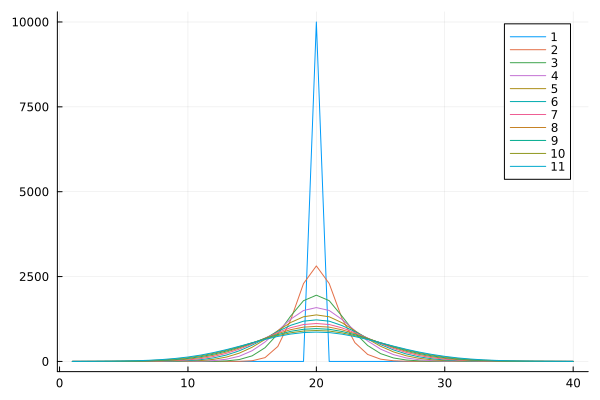

In [20]:
plot()
for (i,c) in enumerate(sols)
    plot!(c, label=i)
end
plot!()

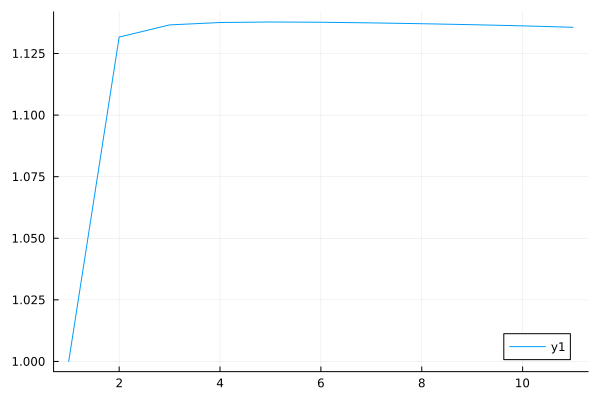

In [21]:
plot([sum(s) for s in sols]*ds)

In [22]:
1+1

2